In [1]:
# packages

import pathlib
import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy import signal
from scipy.optimize import fsolve
from scipy.interpolate import interp2d
from sympy import symbols, Eq, solve, I, cos, exp, pi
import os
os.chdir(os.path.abspath(''))


In [51]:
# functions

def compute_matrices(theta_blade, theta_yaw, theta_tilt, theta_cone):

    a1 = (  [1,0,0],
            [0, np.cos(theta_yaw), np.sin(theta_yaw)],
            [0, -np.sin(theta_yaw), np.cos(theta_yaw)])
    a2 = (  [np.cos(theta_tilt), 0, -np.sin(theta_tilt)],
            [0, 1, 0],
            [np.sin(theta_tilt), 0, np.cos(theta_tilt)])
    a12 = np.matmul(a2, a1)
    a21 = np.transpose(a12)
    
    a23 = ( [np.cos(theta_blade), np.sin(theta_blade), 0],
            [-np.sin(theta_blade), np.cos(theta_blade), 0],
            [0, 0, 1])
    a34 = ( [np.cos(theta_cone), 0, -np.sin(theta_cone)],
            [0, 1, 0],
            [np.sin(theta_cone), 0, np.cos(theta_cone)])
    
    a14 = np.matmul(np.matmul(a34,a23), a12)
    a41 = np.transpose(a14)

    return a21, a23, a41 

def compute_position(a21, a41, H, Ls, radius):
    
    rt = np.transpose([H,0,0])
    rs = np.matmul(a21, np.transpose([0,0,-Ls]))
    rb = np.matmul(a41, np.transpose([radius,0,0]))
    position = rt + rs + rb
    
    return position

def compute_tower_radius(x):

    if x <= H:
        a = a0
    else:
        a = 0
    
    return a


# interpolate airfoil (provided in course materials)

files=[ 'FFA-W3-241.txt',
        'FFA-W3-301.txt',
        'FFA-W3-360.txt',
        'FFA-W3-480.txt',
        'FFA-W3-600.txt',
        'cylinder.txt']

#Initializing tables    
cl_tab=np.zeros([105,6])
cd_tab=np.zeros([105,6])
cm_tab=np.zeros([105,6])
aoa_tab=np.zeros([105,])
fstat_tab=np.zeros([105,6])
Cl_inv_tab=np.zeros([105,6])
Cl_fs_tab=np.zeros([105,6])

#Reading of tables. Only do this once at startup of simulation
for i in range(np.size(files)):
    aoa_tab[:],cl_tab[:,i],cd_tab[:,i],cm_tab[:,i],fstat_tab[:,i],Cl_inv_tab[:,i],Cl_fs_tab[:,i] = np.loadtxt(files[i], skiprows=0).T

# Thickness of the airfoils considered
# NOTE THAT IN PYTHON THE INTERPOLATION REQUIRES THAT THE VALUES INCREASE IN THE VECTOR!

thick_prof=np.zeros(6)
thick_prof[0]=24.1
thick_prof[1]=30.1
thick_prof[2]=36
thick_prof[3]=48
thick_prof[4]=60
thick_prof[5]=100

def force_coeffs_10MW(angle_of_attack,thick,aoa_tab,cl_tab,cd_tab,cm_tab,fstat_tab, Cl_inv_tab,Cl_fs_tab):
    
    cl_aoa=np.zeros([1,6])
    cd_aoa=np.zeros([1,6])
    cm_aoa=np.zeros([1,6])
    fstat_aoa=np.zeros([1,6])
    Cl_inv_aoa=np.zeros([1,6])
    Cl_fs_aoa=np.zeros([1,6])
    
    #Interpolate to current angle of attack:
    for i in range(np.size(files)):
        cl_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,cl_tab[:,i])
        cd_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,cd_tab[:,i])
        cm_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,cm_tab[:,i])
        fstat_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,fstat_tab[:,i])
        Cl_inv_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,Cl_inv_tab[:,i])
        Cl_fs_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,Cl_fs_tab[:,i])
    
    #Interpolate to current thickness:
    cl=np.interp (thick,thick_prof,cl_aoa[0,:])
    cd=np.interp (thick,thick_prof,cd_aoa[0,:])
    cm=np.interp (thick,thick_prof,cm_aoa[0,:])
    fstat=np.interp (thick,thick_prof,fstat_aoa[0,:])
    cl_inv=np.interp (thick,thick_prof,Cl_inv_aoa[0,:])
    cl_fs=np.interp (thick,thick_prof,Cl_fs_aoa[0,:])

    
    return cl, cd, cm , fstat, cl_inv, cl_fs


# BEM (for 3 blades)

def BEM(turb = False, theta_pitch = 0, omega = 1):
    theta_I = 0 #initial

    theta_blade1_old = 0 # initial position [rad]

    # creating empty arrays to store values
    Wy = np.zeros((len(r_array),B))
    Wz = np.zeros((len(r_array),B))

    Wy_int = np.zeros((len(r_array),B))
    Wz_int = np.zeros((len(r_array),B))

    Wy_qs = np.zeros((len(r_array),B))
    Wz_qs = np.zeros((len(r_array),B))

    P = []
    T = []
    time_array = []
    W_at_r_target = []
    pz_at_r_target = []

    fs_matrix = np.zeros((len(r_array),B))

    theta_pitch_array = []
    omega_array = []

    GF_blade1 = np.zeros((3,num))

    # time step iteration
    for n in range(num):

        # simulation time [s]
        time = n*dt
        time_array.append(time)

        # blade positions [rad]
        theta_blade1 = theta_blade1_old + omega*dt
        theta_blade2 = theta_blade1 + 2*np.pi/B
        theta_blade3 = theta_blade2 + 2*np.pi/B

        theta_blade_array = [theta_blade1, theta_blade2, theta_blade3]

        # empty arrays for storing P and T for all blades in current time step
        P_time = []
        T_time = []
        W_at_r_target_time = []
        pz_at_r_target_time = []

        # blades iteration
        for j in range(B):

            # calculate transformation matrices for current blade position
            a21, a23, a41 = compute_matrices(theta_blade_array[j], theta_yaw, theta_tilt, theta_cone)

            # empty arrays for storing P, T, py, pz values for each segment
            dP_array = []
            dT_array = []

            py_array = np.zeros((B,len(r_array)))
            pz_array = np.zeros((B,len(r_array)))

            # blade segment iteration
            for i in range(len(r_array)):
                # parameters of the segment
                r = r_array[i] # radius [m]
                beta = beta_array[i] # twist angle [rad]
                c = c_array[i] # chord length [m]
                thick_perc = t_perc_array[i] # thickness ratio of blade [%]
                
                # segment position in CS1
                r_1_vec = compute_position(a21, a41, H, Ls, r)

                # wind speed of segment based on wind shear
                V0x = V0*(r_1_vec[0] / H)**nu

                # tower model calculations
                y = r_1_vec[1]
                z = r_1_vec[2]
                r_1 = np.sqrt(y**2 + z**2)
                a_tower = compute_tower_radius(r_1_vec[0]) # tower radius at current height [m]

                Vr =     z/r_1 * V0x * (1 - (a_tower/r_1)**2)
                Vtheta = y/r_1 * V0x * (1 + (a_tower/r_1)**2)

                if turb == True:
                    # calculating the fluctuating component (interpolation)
                    f_u = interp2d(y_sample, x_sample, fluc_x[n])
                    f_v = interp2d(y_sample, x_sample, fluc_y[n])
                    f_w = interp2d(y_sample, x_sample, fluc_z[n])

                    # final wind components in CS1 [m/s]
                    Vx = float(0 + f_u(y, z))
                    Vy = float(y/r_1 * Vr - z/r_1 * Vtheta + f_v(y, z))
                    Vz = float(z/r_1 * Vr + y/r_1 * Vtheta + f_w(y, z))
                else:
                    # final wind components in CS1 [m/s]
                    Vx = 0
                    Vy = y/r_1 * Vr - z/r_1 * Vtheta
                    Vz = z/r_1 * Vr + y/r_1 * Vtheta

                # total velocity
                a14 = np.transpose(a41)
                V0_1 = [Vx, Vy, Vz] # wind speed in CS1 [m/s]
                V0_4 = np.matmul(a14, np.transpose(V0_1)) # wind speed in CS4 [m/s]
                V0_magn = np.linalg.norm(V0_4) # magnitude of local wind considering wind shear and tower effect
                
                # relative wind speeds (CS4) [m/s]
                Vrel_y = V0_4[1] + Wy[i,j] - omega*r*np.cos(theta_cone) # tangential
                Vrel_z = V0_4[2] + Wz[i,j] # normal
                Vrel = np.sqrt(Vrel_y**2 + Vrel_z**2) # magnitude

                phi = np.arctan(- Vrel_z/Vrel_y) # flow angle [rad]
                alpha = phi - (beta + theta_pitch) # angle of attack [rad]

                # lift and drag coefficients
            
                fs = fs_matrix[i,j]

                fs_old = fs
                Cl, Cd, Cm, fstat, Cl_inv, Cl_fs = force_coeffs_10MW(np.rad2deg(alpha),thick_perc,aoa_tab,cl_tab,cd_tab,cm_tab,fstat_tab, Cl_inv_tab,Cl_fs_tab)
                tau = 4 * c / Vrel
                fs = fstat + (fs_old - fstat) * np.exp(-dt/tau)
                Cl = fs * Cl_inv + (1-fs) * Cl_fs

                fs_matrix[i,j] = fs
                
                # induction factor and Glauert correction
                a = - Wz[i,j] / V0            # check what happens with V0_local => is a too much spiky?
                if a <= 1/3:
                    fg = 1
                else:
                    fg = 1/4* (5-3*a)

                # # induction factor Wilson-Walker
                # a = - Wz[i,j] / V0            # check what happens with V0_local => is a too much spiky?
                # if a <= 0.2:
                #     fg = 1
                # else:
                #     fg = 0.2/a * (2 - 0.2/a)
                
                # Prandtl tip loss correction
                F = 2/np.pi * np.arccos(np.exp(-B/2 * (R-r)/(r*np.sin(np.abs(phi)))))

                # lift and drag forces [N/m]
                l = 0.5*rho*Vrel**2 * c * Cl # lift
                d = 0.5*rho*Vrel**2 * c * Cd # drag

                # normal and tangential loads [N/m]
                pz = l*np.cos(phi) + d*np.sin(phi) # normal
                py = l*np.sin(phi) - d*np.cos(phi) # tangential

                # quasi-steady induced wind
                Wy_qs_new = (- B * l * np.sin(phi)) / (4*np.pi * rho * r * F * np.sqrt(V0_4[1]**2 + (V0_4[2] + fg*Wz[i,j])**2))
                Wz_qs_new = (- B * l * np.cos(phi)) / (4*np.pi * rho * r * F * np.sqrt(V0_4[1]**2 + (V0_4[2] + fg*Wz[i,j])**2))

                # # approach from last semester
                # Wy_qs_new = (- B * py) / (4*np.pi * rho * r * F * np.sqrt(V0_4[1]**2 + (V0_4[2] + fg*Wz[i,j])**2))
                # Wz_qs_new = (- B * pz) / (4*np.pi * rho * r * F * np.sqrt(V0_4[1]**2 + (V0_4[2] + fg*Wz[i,j])**2))
            
                # updating induced wind
                k = 0.6
                tau_1 = 1.1/(1-1.3*a) * R/V0  #time constant 1
                tau_2 = (0.39-0.26 * (r/R)**2) * tau_1 #time constant 2

                RHS_y = Wy_qs_new + k * tau_1 * (Wy_qs_new - Wy_qs[i,j]) / dt
                Wy_int[i,j] = RHS_y + (Wy_int[i,j] - RHS_y) * np.exp(-dt/tau_1)
                Wy[i,j] = Wy_int[i,j] + (Wy[i,j] - Wy_int[i,j]) * np.exp(-dt/tau_2)
                # Wy[i,j] = Wy_qs_new  # killing the dynamic wake model for faster convergence

                RHS_z = Wz_qs_new + k * tau_1 * (Wz_qs_new - Wz_qs[i,j]) / dt
                Wz_int[i,j] = RHS_z + (Wz_int[i,j] - RHS_z) * np.exp(-dt/tau_1)
                Wz[i,j] = Wz_int[i,j] + (Wz[i,j] - Wz_int[i,j]) * np.exp(-dt/tau_2)
                # Wz[i,j] = Wz_qs_new  # killing the dynamic wake model for faster convergence
                
                Wy_qs[i,j] = Wy_qs_new
                Wz_qs[i,j] = Wz_qs_new

                # power and thrust of segment
                dP = omega*py*r # power
                dT = pz # thrust

                dP_array.append(dP)
                dT_array.append(dT)

                py_array[j,i] = py
                pz_array[j,i] = pz

            # integrating segment values to get P and T per blade
            P_blade = integrate.simpson(y=dP_array, x=r_array)
            T_blade = integrate.simpson(y=dT_array, x=r_array)
            
            P_time.append(P_blade)
            T_time.append(T_blade)
            #W_at_r_target_time.append(np.sqrt(Wz[id_target,j]**2 + Wy[id_target,j]**2))
            #pz_at_r_target_time.append(pz_array[id_target])

            
   
        # EIGEN

        print('py',py_array[0,:])

        GF1 = integrate.simpson(y=py_array[0,:]*u1fy_array, x=r_array) + integrate.simpson(y=pz_array[0,:]*u1fz_array, x=r_array)
        GF2 = integrate.simpson(y=py_array[0,:]*u1ey_array, x=r_array) + integrate.simpson(y=pz_array[0,:]*u1ez_array, x=r_array)
        GF3 = integrate.simpson(y=py_array[0,:]*u2fy_array, x=r_array) + integrate.simpson(y=pz_array[0,:]*u2fz_array, x=r_array)

        GF_blade1[0,n] = GF1
        GF_blade1[1,n] = GF2
        GF_blade1[2,n] = GF3

        
        P.append(P_time)
        T.append(T_time)
        #W_at_r_target.append(W_at_r_target_time)
        #pz_at_r_target.append(pz_at_r_target_time)

        # updating blade location
        theta_blade1_old = theta_blade1

        #CONTROL
        GK = 1/(1+theta_pitch/K1)
        theta_P = GK * Kp * (omega - omega_ref)
        theta_I = theta_I +  GK * Ki * (omega - omega_ref) * dt
        theta_sp = theta_P + theta_I
        
        if theta_sp > theta_pitch + dtheta_pitch * dt:
            theta_sp = theta_pitch + dtheta_pitch * dt
        elif theta_sp < theta_pitch - dtheta_pitch * dt:
            theta_sp = theta_pitch - dtheta_pitch * dt

        if theta_sp > theta_pitch_max:
            theta_sp = theta_pitch_max
        elif theta_sp < theta_pitch_min:
            theta_sp = theta_pitch_min

        theta_pitch = theta_sp
        M_aero = sum(P[-1])/omega

        if omega > omega_rated:
            M_g = P_rated / omega_rated
        else:
            M_g = K * omega**2
        omega = omega + (M_aero - M_g)/I * dt

        omega_array.append(omega)
        theta_pitch_array.append(theta_pitch)

    #return np.array(P), np.array(T), np.array(time_array), py_array, pz_array, np.array(W_at_r_target), np.array(pz_at_r_target),omega_array,theta_pitch_array
    return GF_blade1, np.array(time_array)


def load(filename, N=(32, 32)):

    data = np.fromfile(filename, np.dtype('<f'), -1)
    if len(N) == 2:
        ny, nz = N
        nx = len(data) / (ny * nz)
        assert nx == int(nx), "Size of turbulence box (%d) does not match ny x nz (%d), nx=%.2f" % (
            len(data), ny * nz, nx)
        nx = int(nx)
    else:
        nx, ny, nz = N
        assert len(data) == nx * ny * \
            nz, "Size of turbulence box (%d) does not match nx x ny x nz (%d)" % (len(data), nx * ny * nz)
    return data.reshape(nx, ny * nz)


In [25]:
# data

blade = pd.read_csv('bladedat.txt',delimiter='\t',header=None,names=['r','beta','c','t_perc'])
r_array = blade['r'] # radius [m]
beta_array = np.deg2rad(blade['beta']) # twist angle [rad]
c_array = blade['c'] # chord length [m]
t_perc_array = blade['t_perc'] # thickness ratio [%]

modeshape = pd.read_csv('modeshapes.txt',delim_whitespace=True,header=2,names=['r', 'u1fy','u1fz','u1ey','u1ez', 'u2fy', 'u2fz', 'm'])
new_row = pd.DataFrame({'r': [2.8000], 'u1fy': [0], 'u1fz': [0], 'u1ey': [0], 'u1ez': [0], 'u2fy': [0], 'u2fz': [0], 'm': [1189.51],}) 
modeshape = pd.concat([new_row, modeshape]).reset_index(drop=True)

u1fy_array = modeshape['u1fy']
u1fz_array = modeshape['u1fz']
u1ey_array = modeshape['u1ey']
u1ez_array = modeshape['u1ez']
u2fy_array = modeshape['u2fy']
u2fz_array = modeshape['u2fz']
m_array = modeshape['m']

omega1f=3.93
omega1e=6.10
omega2f=11.28

In [35]:
# build matrices

GM1 = integrate.simpson(y=u1fy_array**2 * m_array , x=r_array) + integrate.simpson(y=u1fz_array**2 * m_array , x=r_array)
GM2 = integrate.simpson(y=u1ey_array**2 * m_array , x=r_array) + integrate.simpson(y=u1ez_array**2 * m_array , x=r_array)
GM3 = integrate.simpson(y=u2fy_array**2 * m_array , x=r_array) + integrate.simpson(y=u2fz_array**2 * m_array , x=r_array)

M = np.zeros((3,3))
M[0,0] = GM1
M[1,1] = GM2
M[2,2] = GM3

K = np.zeros((3,3))
K[0,0] = GM1*omega1f**2
K[1,1] = GM2*omega1e**2
K[2,2] = GM3*omega2f**2

delta = 0.03
C = np.zeros((3,3))
C[0,0] = GM1*omega1f*delta/np.pi
C[1,1] = GM2*omega1e*delta/np.pi
C[2,2] = GM3*omega2f*delta/np.pi
# delta to be corrected

print(M)
print(K)




[[1446.9686627     0.            0.        ]
 [   0.         2058.56418947    0.        ]
 [   0.            0.          659.76750985]]
[[22348.28629854     0.             0.        ]
 [    0.         76599.17349026     0.        ]
 [    0.             0.         83947.76232543]]


In [43]:
# global + Q1 data

B = 3 # number of blades
rho = 1.225 # air density [kg/m3]
R = 89.17 # rotor diameter [m]

#omega = 7.229 *2*np.pi/60 # rotational speed [rad/s]
H = 119 # hub height [m]
Ls = 7.1 # length of nacelle [m]
a0 = 0 # tower radius [m]    

r_target = 65.75 # radius of the interesting blade segment [m]
id_target = 9 # index of the interesting blade segment

# reading blade geometry data from file
blade = pd.read_csv('bladedat.txt',delimiter='\t',header=None,names=['r','beta','c','t_perc'])
r_array = blade['r'] # radius [m]
beta_array = np.deg2rad(blade['beta']) # twist angle [rad]
c_array = blade['c'] # chord length [m]
t_perc_array = blade['t_perc'] # thickness ratio [%]

# wind
nu = 0.0 # wind shear exponent
V0 = 15 # mean wind speed at hub height [m/s]

# NO IDEA WHETHER WE NEED TOWER EFFECT OR NOT
# adding tower effect
# a0 = 3.32 # tower radius [m]

# simulation parameters
#t_total = 10 # total time of simulation [s]
dt = 0.1 # time step size [s]
num = int(t_total / dt)+1 # number of time steps

# angles
theta_yaw = np.deg2rad(0) # yaw angle [rad]
theta_tilt = np.deg2rad(0) # tilt angle [rad]
theta_cone = np.deg2rad(0) # cone angle [rad]

Ki = 0.64 #radians
Kp = 1.5 #radians
K1 = np.deg2rad(14)
I = 1.6e8
theta_pitch_min = 0
theta_pitch_max = np.deg2rad(45)
dtheta_pitch = np.deg2rad(9) #rad/s
omega_rated = 1.02265
omega_ref = 1.01 * omega_rated
P_rated = 10.64e6
lam = 8
c_P = 0.4662 #c_p optimal
K = 0.5 * rho * np.pi*R**2 * R**3 * c_P/lam**3
V_rated = (R*omega_rated)/lam
#K = P_rated/omega_rated**3

py [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
py [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
py [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
py [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
py [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
py [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
py [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
py [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
py [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
py [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
py [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
py [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
py [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
py [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
py [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
py [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
py [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

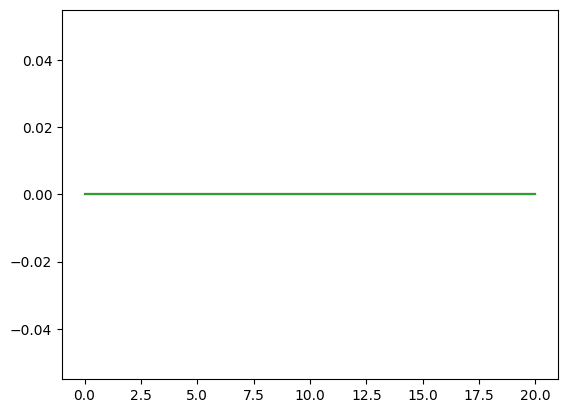

In [52]:
# test

t_total = 20 # total time of simulation [s]
dt = 0.1 # time step size [s]
num = int(t_total / dt)+1 # number of time steps

GF_blade1, time = BEM()

print(GF_blade1)


plt.plot(time, GF_blade1.T)
plt.show()

In [4]:
# Q1 calculation

# simulation parameters
t_total = 120 # total time of simulation [s]
dt = 0.1 # time step size [s]
num = int(t_total / dt)+1 # number of time steps

V0_array = np.arange(4,25,2)

P_array = []
rot_speed = []
pitch_array = []
c_P_array = []

P_conv_check = []
omega_conv_check = []
pitch_conv_check = []

df_power = pd.DataFrame()
df_ = pd.DataFrame()
df_ = pd.DataFrame()

for V0 in V0_array:
    P, T, time, pt, pn, W_at_seg, pn_at_seg, omega, theta_p = BEM()

    df_power[f'P_{V0}'] = P
    
    P_array.append(sum(P[-1]))
    rot_speed.append(omega[-1])
    pitch_array.append(theta_p[-1])
    c_P_array.append(sum(P[-1])/(rho/2 * V0**3 * np.pi*R**2))

    P_conv_check.append([sum(sublist) for sublist in P])
    omega_conv_check.append(omega)
    pitch_conv_check.append(theta_p)

P_conv_check = [[row[i] for row in P_conv_check] for i in range(len(P_conv_check[0]))]
omega_conv_check = [[row[i] for row in omega_conv_check] for i in range(len(omega_conv_check[0]))]
pitch_conv_check = [[row[i] for row in pitch_conv_check] for i in range(len(pitch_conv_check[0]))]